#**Prérequis**
<ins> Durée : 70 heures</ins> \\
Pour ce projet, il sera utile de savoir réaliser une analyse de statistique descriptive en langages R ou Python (avec des représentations graphiques). Il faudra également appliquer des modélisations de type ANOVA ou régression linéaire.


#**Scénario**
Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.
 
Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.
L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.
Très bien."Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"


Avec aussi peu de données disponibles, cela semble être un sacré challenge !
Ainsi, vous proposez une régression linéaire avec 3 variables :


*   le revenu des parents
*   le revenu moyen du pays dans lequel habite le prospect
*   l'indice de Gini calculé sur les revenus des habitants du pays en question

Ce projet ne traite que de la construction et de l'interprétation du modèle. Vous n'irez pas jusqu'à la phase de prédiction


#**Les données**
Ce fichier contient les données de la [World Income Distribution]( https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/data-projet7.csv), datée de 2008. Cette base de données est composée principalement d'études réalisées au niveau national pour bon nombre de pays, et contient les distributions de revenus des populations concernées.
 
Vous téléchargerez également les indices de Gini estimés par la Banque mondiale, disponibles [ à cette adresse](https://data.worldbank.org/indicator/SI.POV.GINI). Libre à vous de trouver également d'autres sources, ou de recalculer les indices de Gini à partir de la World Income Distribution.
Vous aurez également besoin de récupérer le nombre d'habitants de chaque pays présent dans votre base.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 2.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/data-projet7.csv')
gini_ind=pd.read_excel('/content/drive/MyDrive/Gini_tab.xls')
pop=pd.read_excel('/content/drive/MyDrive/pop_2008.xls')
gini_ind.rename(columns={'year':'gini_index'}, inplace=True)
pop.rename(columns={'year':'population'}, inplace=True)

Mounted at /content/drive


In [ ]:
gini_ind.head(3)

,Country Name,country,gini_index
0,Aruba,ABW,NaN
1,Africa Eastern and Southern,AFE,NaN
2,Afghanistan,AFG,NaN


Nous allons resteindre notre étude à l'année 2008.

In [ ]:
data=data[data['year_survey']==2008]
data.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297


- Vérifions si les types de chaque attribut sont au format adéquat

In [ ]:
#Type de chaque attribut de notre tableau
print(data.dtypes)
# On remplace les , par des . pour que la conversion puisse se faire
data['income']=data['income'].str.replace(",",".")
data['gdpppp']=data['gdpppp'].str.replace(",",".")
#Conversion du type de income en float 
data.income=data.income.astype(str).astype(float)
data.gdpppp=data.gdpppp.astype(str).astype(float)

country         object
year_survey      int64
quantile         int64
nb_quantiles     int64
income          object
gdpppp          object
dtype: object


- Vérification des données manquantes
- Vérification des doublons
- Vérifier si il n'y a d'erreurs de saisie

In [ ]:
# On vérifie si il y a des valeur Nan dans notre table
print(data.isnull().sum())

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          100
dtype: int64


Il y a 200 valeurs manquantes dans la colonne gdpppp. On supprime les lignes où il y a des valeurs manquantes, ceci sera sans réelle incidence sur notre étude.

In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
# On vétrifie si il ya des doublons dans notre table
# Affiche toutes les autres occurences d'une ligne (sauf la première).
duplicateRowsDF= data[data.duplicated(keep='first')]  #keep=last
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [country, year_survey, quantile, nb_quantiles, income, gdpppp]
Index: []


Il n'y a pas de doublons dans notre tableau.

In [ ]:
#On vérifie si il y a des revenus négatifs 
print(data[data.income<1])

Empty DataFrame
Columns: [country, year_survey, quantile, nb_quantiles, income, gdpppp]
Index: []


In [ ]:
data.count()

country         7499
year_survey     7499
quantile        7499
nb_quantiles    7499
income          7499
gdpppp          7499
dtype: int64

In [ ]:
#On vérifie si chaque pays a tous les centiles 
t=data.groupby('country').agg('count')
t[t.income <100]

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,99,99,99,99,99


Pour chaque pays la population a été divisée en 100 groupes. Mais là on remarque que pour la Lutuanie on a que 99 groupes dans notre jeu de données. Ce qui pose problème vu qu'on doit avoir 100 groupes par ce pays. Poussons un peu l'analyse pour voir où se trouve l'erreur. 

In [ ]:
group_lut=set(data[data.country=='LTU']['quantile']) # tous les groupes du pays 
num_group=set( list(range(1,101)) )
c=num_group.difference(group_lut)
print(c)

{41}


Nous pouvons remarque d'après la vérification ci-dessus que pour la Lutuanie le centile 41 (le groupe 41) est manquant. En effet on observe dans la colonne quantile de La Lutuanie un saut du groupe 40 au groupe 42. Pour corriger cette omission on va inserer dans notre une nouvelle ligne pour le groupe 41 de la lutuanie. 

In [ ]:
# La ligne à rajouter
new_row = {'country':'LTU', 'year_survey':2008, 'quantile':41, 'nb_quantiles':100,'income':4882.1405,'gdpppp':17571 }
data=data.append(new_row, ignore_index=True)
#On reindexe la ligne ajoutée pour qu'elle soit à la bonne position
data=data.sort_values(by=['country','quantile'],ignore_index=True)
data[data.country=='LTU']

,country,year_survey,quantile,nb_quantiles,income,gdpppp
4500,LTU,2008,1,100,566.3453,17571.0
4501,LTU,2008,2,100,1147.0587,17571.0
4502,LTU,2008,3,100,1490.8408,17571.0
4503,LTU,2008,4,100,1746.5715,17571.0
4504,LTU,2008,5,100,1842.9542,17571.0
...,...,...,...,...,...,...
4595,LTU,2008,96,100,14597.0360,17571.0
4596,LTU,2008,97,100,15659.0080,17571.0
4597,LTU,2008,98,100,17883.8770,17571.0
4598,LTU,2008,99,100,22551.1700,17571.0


<ins>Calcul de l'indice de Gini

In [ ]:
data_test=data.copy() 
data.set_index('country',inplace=True)
# Création de la colonne contenant la part cumulée de revenu pour chaque pays
data['income_freq_cc']=None
# Création de la colonne contenant l'indice de Gini pour chaque pays
data['indice_gini']=None

In [ ]:
#Calcul de la part cumulées de revenus pour chaque pays
for pays in (set((data.index))):
  data.loc[pays,'income_freq_cc']=np.cumsum(data.loc[pays,'income']/data.loc[pays,'income'].sum())

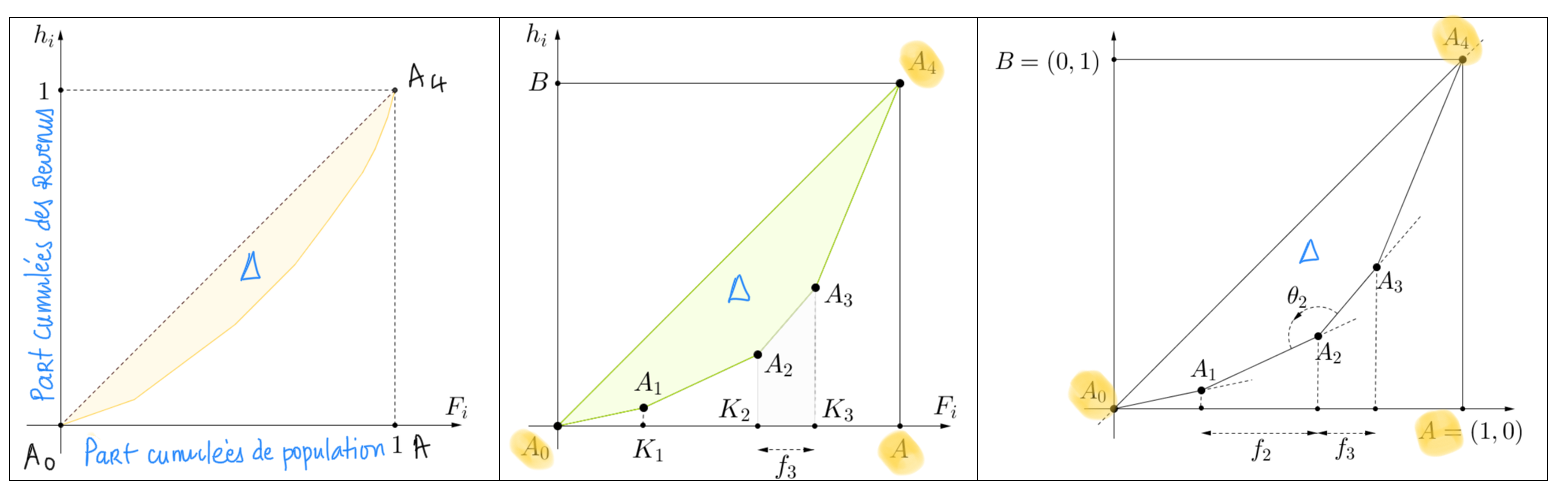

Définition. On appelle indice de Gini de la série ${(x_1,n_1),⋯,(x_k,n_k)}$ le rapport de l’aire du polygone $Δ=A_0A_1⋯Ak$ à celle du triangle $A_0AA_k$ : \\
<center> $I_G=\frac{aire(Δ)}{aire(A_0AA_k)}=\frac{aire(Δ)}{\frac{1}{2}}=2×aire(Δ)$ </center> \\

<center> $I_G=\frac{aire(Δ)}{aire(A_0AA_k)} \\ \quad \quad =2×aire(Δ) \\ \\ \quad \quad 
=2× (aire(A_0AA_k)-aire(A_0A_1⋯A_kA)) \\ \quad \quad 
=2× (\frac{1}{2}-aire(A_0A_1⋯A_kA)) \\ \quad \quad  = 1-2×aire(A_0A_1⋯A_kA) 
\\ \quad \quad  =1-2 × (\frac{h_1f_1}{2}+\frac{(h_1+h_2)f_2}{2}+...+\frac{(h_{k-1}+h_k)f_k}{2}) \\ \quad \quad  =1-( h_1f_1+(h_1+h_2)f_2+...+(h_{k-1}+h_k)f_k) \\ \quad \quad  = 1-\sum_{i=1}^k(h_{i-1}+h_i)f_i $ </center> 

Finalement <ins>*Indice de Gini*</ins> $= 1-\sum_{i=1}^k(h_{i-1}+h_i)f_i$   



In [ ]:
#Calcul de l'indice de Gini de chaque pays
for pays in (set((data.index))):
  fi=0.01 # ecart entre deux freq cumulées de la population
  hi_1=np.append(0,data.loc[pays,'income_freq_cc'][0:99])
  hi=data.loc[pays,'income_freq_cc']
  data.loc[pays,'indice_gini']=1-sum((hi_1+hi)*fi)

In [ ]:
l=data.index
table_gini=set(gini_ind['country'])
mes_données=set(l)
c=mes_données.difference(table_gini) # les pays qui sont dans mes données mais ne sont pas dans table_gini
print(c)

{'TWN'}


On joint les tables gini_ind et data pour rajouter l'index de gini chaque pays à la table data.

In [ ]:
data.reset_index(inplace=True)
data=pd.merge(data, gini_ind, how='inner', on='country')

#Je normalise les valeurs de la colonne Gini_index pour qu'elles soient entre 0 et 1.
data['gini_index']=data['gini_index']/100

Puisque j'ai recalculé l'indice de Gini de chaque pays, il me faut vérifier que les valeurs que j'ai obtenues en calculant s'approchent des valeurs présentes dans les données officielles. Pour vérifier cela j'ai,dans un premier temps comparé valeur par valeur les deux colonnes à la l'aide de graphique,  puis dans un deuxième temps  calculé l'écart entre mes valeurs et les valeurs issues de données officielles. 

In [ ]:
compare_gini=data[data["gini_index"].notna()]

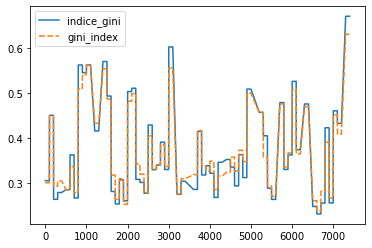

In [ ]:
import seaborn as sns
sns.lineplot(data=compare_gini[['indice_gini','gini_index']])

On remarque l'allure des deux courbes sont assez similaires. L'indice de gini calculé est assez proche de l'indice de gini obtenu à partir des données officielles.

In [ ]:
import math
compare_gini['ecart']=abs(compare_gini['gini_index']-compare_gini['indice_gini'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
compare_gini= pd.DataFrame(compare_gini.groupby('country').first().reset_index())

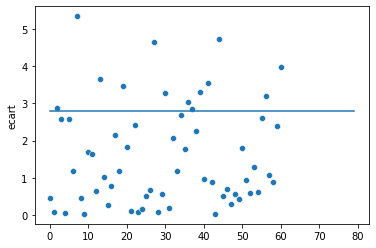

In [ ]:
sns.scatterplot(data=compare_gini['ecart']*100)
sns.lineplot(data=np.repeat(2.8,80))

In [ ]:
compare_gini['ecart'].quantile(0.81)*100

2.8781086962074633

A partir du graphique tracé et du quantile on voit bien que pour 80% des valeurs des deux colonnes 'indice_gini' et 'gini_index' l'écart est inférieur à 2.87.

In [ ]:
from scipy.stats import shapiro
#perform Shapiro-Wilk test
shapiro(compare_gini['gini_index'])

(0.9189590811729431, 0.0006239077774807811)

#Mission 1
##1
Résumez les données utilisées :
*  année(s) des données utilisées ;
*  nombre de pays présents ;
*  population couverte par l'analyse (en termes de pourcentage de la population mondiale).


In [ ]:
print('année des données utilisées :', set(data.year_survey))
print('Nombre de pays présents :',len(set(data['country'])))

année des données utilisées : {2008}
Nombre de pays présents : 74


Rajoutons dans notre table data la population de chaque pays.

In [ ]:
data=pd.merge(data,pop, how='inner', on='country')

population couverte par l'analyse (en termes de pourcentage de la population mondiale).

In [ ]:
print(round((data.groupby('country').first().sum()['population'] / 6.7E9)*100,2),'%')

34.36 %


## 2
Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.
*  De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
*  Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.
 

In [ ]:
#il s'agit de centile

##3
L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

#Mission 2
* Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
* Représentez la courbe de Lorenz de chacun des pays choisis.
* Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
* Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. Dans quelle position se trouve la France ?


#Mission 3
Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
$(m_{j})$ le revenu moyen du pays  $(j)$,
$(G_{j})$ l'indice de Gini du pays $(j)$
Il nous manque donc, pour un individu  $(i)$ , la classe de revenu $(c_{i,parent})$ de ses parents. \\
Nous supposons ici que l'on associe à chaque individu $(i)$ une unique classe $(c_{i,parent})$ ; quel que soit le nombre de parents de $(i)$. \\
Nous allons donc simuler cette information grâce à un coefficient $(rho_{j})$ (propre à chaque pays $(j)$ ), mesurant une corrélation entre le revenu de l'individu $(i)$ et le revenu de ses parents. Ce coefficient sera ici appelé coefficient d'élasticité ; il mesure la mobilité intergénérationnelle du revenu.
Pour plus d'informations sur le calcul du coefficient d'élasticité, consulter [ce document](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf), notamment l'équation 1 de la page 8. Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant $(Y_{child})$ est une fonction du logarithme du revenu des parents $(Y_{parent})$ : \\
$\quad  ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon$ \\
Pour obtenir le coefficient d'élasticité, deux possibilités s'offrent à vous :

* Vous baser sur ces coefficients donnés par la Banque mondiale, dans [GDIM dataset](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/DANV1_P7/GDIMMay2018+(1).csv). Le coefficient d'élasticité est donné pour certains pays, sous le nom d'IGE Income (relative IGM in income).
* Vous baser sur des estimations provenant de multiples études, extrapolées à différentes régions du monde :  elles se trouvent dans le fichier [elasticity.txt](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/projet_7.zip). Attention, ces données sont parfois anciennes. \\

Il est aussi possible de combiner ces deux approches.
Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations : \\
* $(\rho_j)$
* la classe de revenu de l'enfant  $(c_{i,child})$.
Attention à bien utiliser la classe de revenu de l'enfant (qui est un nombre compris entre 1 et 100 si vous utilisez 100 quantiles), plutôt que son revenu PPP. De même, on ne cherche pas à générer le revenu des parents, mais la classe de revenu des parents $(c_{i,parent})$.
Voici le protocole de génération pour un pays $(j)$ donné, qui se base sur l'équation donnée ci dessus :
Un exemple de code permettant de réaliser les opérations 1 à 6 est donné tout en bas. Libre à vous de l'utiliser. Notamment, la fonction  proba_cond  vous donnera les probabilités $(P(c_{i,parent}|c_{i,child},j))$.
1. Générez un grand nombre $(n)$ de réalisations d'une variable que nous 
appellerons  $(ln(Y_{parent}))$ selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. $(n)$ doit être supérieur à 1000 fois le nombre de quantiles.
2. Générez $(n)$ réalisations du terme d'erreur $(\epsilon)$ selon une loi normale de moyenne 0 et d'écart type 1. \\
3. Pour une valeur donnée de $(\rho_j)$ (par exemple 0.9), calculez $(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon})$ . Le choix de $( \alpha)$ n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, $(y_{child})$ contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite. \\
4. Pour chacun des $(n)$ individus générés, calculez la classe de revenu  $(c_{i,child})$ ainsi que la classe de revenu de ses parents $(c_{i,parent})$ , à partir de $(y_{child})$ et $(y_{parent})$. \\
5. À partir de cette dernière information, estimez pour chaque  $(c_{i,child})$ la distribution conditionnelle de $(c_{i,parent})$ . Par exemple, si vous observez 6 individus ayant à la fois  $(c_{i,child} = 5)$ et $(c_{i,parent} = 8)$ , et que 200 individus sur 20000 ont $( c_{i,child} = 5)$ , alors la probabilité d'avoir $( c_{i,parent} = 8)$ sachant  $(c_{i,child} = 5)$ et sachant $(\rho_j=0.9)$ sera estimée à 6/200 (On note cette probabilité comme ceci : $(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03))$. Si votre population est divisée en $(c)$ classes de revenu, vous devriez alors avoir $(c^2)$estimations de ces probabilités conditionnelles, pour chaque pays.
6. Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de $(\rho_j)$ : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9) :  \\

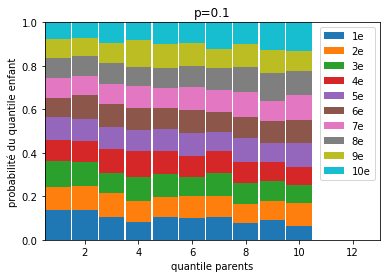


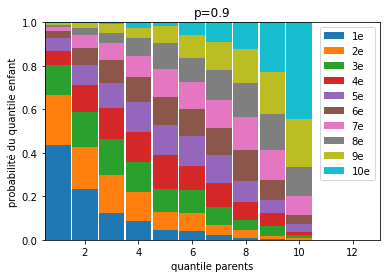


7. Faible mobilité
8. Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.
9. Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.
10. Pour chaque $(c_{i,child})$ et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes $( c_{i,parent})$ conformément aux distributions trouvées précédemment. Par exemple, si $(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03)$ , alors vous assignerez la classe $(c_{i,parent} = 8)$ à 15 des 500 individus du pays $( j)$ ayant $(c_{i,child}=5)$ , car $500*0.03 = 15$.
11. Éventuellement et pour éviter toute confusion, effacez la variable $(c_{i,child})$  : nous n'en avons pas besoin pour la mission 4.
12. Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : $(m_j)$ et $(G_j)$ .
Utilisez ce nouvel échantillon pour la mission 4.


#Mission 4
Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.
Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle. \\
Pour chacune des régressions suivantes, vous testerez 2 version : l'une en exprimant le revenu moyen du pays et les revenus (parents & enfants) en logarithme (ln), l'autre en les laissant tels quels. Vous choisirez la version la plus performante pour répondre aux question. \\
Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ? \\
Selon ce modèle, donnez la décomposition de variance totale expliquée par : \\
* le pays de naissance (ie. le revenu moyen et l’indice de Gini) ;
* les autres facteurs non considérés dans le modèle (efforts, chance, etc.).
Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?
En observant le coefficient de régression associé à l’indice de Gini, peut-on affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?
Selon ce dernier modèle, donnez la décomposition de variance totale expliquée par : \\
* le pays de naissance et le revenu des parents
* les autres facteurs non considérés dans le modèle (efforts, chance, etc.)
 


#Annexe : code
Voici le code évoqué dans la mission 3, libre à vous de l'utiliser ou pas :

```
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter
 

 
def generate_incomes(n, pj):
   # On génère les revenus des parents (exprimés en logs) selon une loi normale.
   # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
   ln_y_parent = st.norm(0,1).rvs(size=n)
   # Génération d'une réalisation du terme d'erreur epsilon
   residues = st.norm(0,1).rvs(size=n)
   return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
 
   
def quantiles(l, nb_quantiles):
 
   size = len(l)
 
   l_sorted = l.copy()
 
   l_sorted = l_sorted.sort_values()
 
   quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
 
   q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
 
   return pd.Series([q_dict[e] for e in l])
 
def compute_quantiles(y_child, y_parents, nb_quantiles):
 
   y_child = pd.Series(y_child)
 
   y_parents = pd.Series(y_parents)
 
   c_i_child = quantiles(y_child, nb_quantiles)
 
   c_i_parent = quantiles(y_parents, nb_quantiles)
 
   sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
 
   sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
 
   return sample
 
def distribution(counts, nb_quantiles):
 
   distrib = []
 
   total = counts["counts"].sum()
 
   
   if total == 0 :
 
      return [0] * nb_quantiles
  
 
   for q_p in range(1, nb_quantiles+1):
 
      subset = counts[counts.c_i_parent == q_p]
 
      if len(subset):
 
         nb = subset["counts"].values[0]
 
         distrib += [nb / total]
 
      else:
 
         distrib += [0]
 
   return distrib   
 
 
def conditional_distributions(sample, nb_quantiles):
 
   counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
 
   counts = counts.reset_index()
 
   counts.columns = ["c_i_child","c_i_parent","counts"] 
 
   mat = []
 
   for child_quantile in np.arange(nb_quantiles)+1:
 
      subset = counts[counts.c_i_child == child_quantile]
 
      mat += [distribution(subset, nb_quantiles)]
 
   return np.array(mat) 
 
def plot_conditional_distributions(p, cd, nb_quantiles):
 
   plt.figure()
 
   # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
 
   cumul = np.array([0] * nb_quantiles)
 
   for i, child_quantile in enumerate(cd):
 
      plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
 
      cumul = cumul + np.array(child_quantile)
 
   plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
 
   plt.title("p=" + str(p))
 
   plt.legend()
 
   plt.xlabel("quantile parents")
 
   plt.ylabel("probabilité du quantile enfant")
 
   plt.show()
 
def proba_cond(c_i_parent, c_i_child, mat):
 
   return mat[c_i_child, c_i_parent]
 
 
pj = 0.9                 # coefficient d'élasticité du pays j
 
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
 
n  = 1000*nb_quantiles   # taille de l'échantillon
 
y_child, y_parents = generate_incomes(n, pj)
 
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
 
cd = conditional_distributions(sample, nb_quantiles)
 
#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
 
print(cd)
 
c_i_child = 5 
 
c_i_parent = 8
 
p = proba_cond(c_i_parent, c_i_child, cd)
 
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))
 

```

